In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
df = pd.read_csv("foodprices_indonesia.csv", index_col="month_year")
df

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_price
month_year,,,,,,,,,,,,,,,
1-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,5941.9752
2-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6445.0000
3-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6414.0000
4-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,6083.0000
5-2007,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,5955.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,79087.0000
9-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,68481.0000
10-2019,116.0,Indonesia,0,NaN,974,National Average,604,Chili (bird’s eye) - Retail,0.0,IDR,15,Retail,5,KG,62181.0000


In [53]:
def drop_unused_row_column(df, com_name, is_univariate=True):
    df = df[df["cm_name"].str.contains(com_name)]
    df = df.drop(columns=["adm0_id", "adm0_name", "adm1_id", "adm1_name",
                          "mkt_id", "mkt_name", "cm_id", "cur_id", "cur_name", 
                          "pt_id", "pt_name", "um_id", "um_name"], axis=1)
    if is_univariate:
        df = df.drop("cm_name", axis=1)
    
    return df

In [4]:
def split_data(data, train_all_bound, history_size, train_val_bound=None):
    data_train = []
    labels_train = []
    data_test = []
    labels_test = []
    start_train = history_size
    if train_val_bound is not None:
        data_val = []
        labels_val = []
        end_train = train_val_bound
        start_val = train_val_bound
        end_val = train_all_bound
    else:
        end_train = train_all_bound
    start_test = train_all_bound
    end_test = len(data)
    
    for i in range(start_train, end_train):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data_train.append(np.reshape(data[indices], (history_size, 1)))
        labels_train.append(data[i])
    
    if train_val_bound is not None:
        for i in range(start_val, end_val):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data_val.append(np.reshape(data[indices], (history_size, 1)))
            labels_val.append(data[i])
        
    for i in range(start_test, end_test):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data_test.append(np.reshape(data[indices], (history_size, 1)))
        labels_test.append(data[i])
    
    if train_val_bound is not None:
        return (np.array(data_train), np.array(labels_train), 
    np.array(data_val), np.array(labels_val), 
    np.array(data_test), np.array(labels_test))
    else:
        return np.array(data_train), np.array(labels_train), np.array(data_test), np.array(labels_test)

In [34]:
def create_model(unit, input_shape, kernel_regularizer=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(unit, input_shape=input_shape, kernel_regularizer=kernel_regularizer),
        tf.keras.layers.Dense(1)
    ])
    
    model.summary()
    
    return model

In [72]:
def plot_model_result(history):
    plt.figure(figsize=(10,10))
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Train the forecasting model with Chili (Red) data

select only the "Chili (red)" data

In [17]:
df_chili = drop_unused_row_column(df, "Chili (red) - Retail")
data = df_chili["mp_price"].values / 1000
len(data)

155

define hyperparameters

In [59]:
#hyperparameters
TRAIN_TEST_SPLIT = math.ceil(len(data) * 0.9)
VAL_SPLIT = math.ceil(TRAIN_TEST_SPLIT * 0.9)
HISTORY_SIZE = 10
BUFFER_SIZE = 1000
BATCH_SIZE = 5

UNIT_SIZE = 11
EPOCHS = 250

split the data into train, validation, and test set

In [36]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, TRAIN_TEST_SPLIT, HISTORY_SIZE, VAL_SPLIT)
len(x_train), len(x_val), len(x_test)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test = test.batch(BATCH_SIZE).repeat()

build a forecasting model

In [74]:
chili_model = create_model(UNIT_SIZE, x_train.shape[-2:])
#chili_model.load_weights("chili.h5")
chili_model.compile(optimizer='adam', loss='mse')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 11)                572       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 12        
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________


train with defined hyperparamters

In [61]:
history = chili_model.fit(train, epochs=EPOCHS, steps_per_epoch=len(x_train), 
                validation_data=val, validation_steps=len(x_train))

Epoch 1/250
116/116 [==============================] - 5s 44ms/step - loss: 845.4029 - val_loss: 1519.3919
Epoch 2/250
116/116 [==============================] - 2s 18ms/step - loss: 731.5039 - val_loss: 1375.9823
Epoch 3/250
116/116 [==============================] - 2s 18ms/step - loss: 652.3071 - val_loss: 1215.4232
Epoch 4/250
116/116 [==============================] - 2s 18ms/step - loss: 542.8990 - val_loss: 1136.5858
Epoch 5/250
116/116 [==============================] - 3s 23ms/step - loss: 550.0238 - val_loss: 1066.9195
Epoch 6/250
116/116 [==============================] - 2s 19ms/step - loss: 475.1900 - val_loss: 1005.3975
Epoch 7/250
116/116 [==============================] - 2s 20ms/step - loss: 466.7049 - val_loss: 946.7420
Epoch 8/250
116/116 [==============================] - 2s 21ms/step - loss: 404.0960 - val_loss: 893.1683
Epoch 9/250
116/116 [==============================] - 2s 18ms/step - loss: 391.3861 - val_loss: 842.5101
Epoch 10/250
116/116 [==================

116/116 [==============================] - 2s 21ms/step - loss: 28.9174 - val_loss: 19.8786
Epoch 79/250
116/116 [==============================] - 3s 23ms/step - loss: 28.6103 - val_loss: 19.7386
Epoch 80/250
116/116 [==============================] - 3s 26ms/step - loss: 28.1508 - val_loss: 18.5734
Epoch 81/250
116/116 [==============================] - 3s 22ms/step - loss: 28.9540 - val_loss: 15.9729
Epoch 82/250
116/116 [==============================] - 2s 21ms/step - loss: 29.4922 - val_loss: 15.6460
Epoch 83/250
116/116 [==============================] - 3s 23ms/step - loss: 28.4785 - val_loss: 16.2247
Epoch 84/250
116/116 [==============================] - 3s 22ms/step - loss: 27.7819 - val_loss: 14.7450
Epoch 85/250
116/116 [==============================] - 3s 22ms/step - loss: 28.9583 - val_loss: 15.8015
Epoch 86/250
116/116 [==============================] - 3s 22ms/step - loss: 26.4696 - val_loss: 14.2824
Epoch 87/250
116/116 [==============================] - 3s 22ms/step

116/116 [==============================] - 3s 23ms/step - loss: 19.9747 - val_loss: 8.1267
Epoch 156/250
116/116 [==============================] - 3s 22ms/step - loss: 20.0814 - val_loss: 11.5955
Epoch 157/250
116/116 [==============================] - 2s 21ms/step - loss: 20.0321 - val_loss: 9.3236
Epoch 158/250
116/116 [==============================] - 2s 20ms/step - loss: 19.8631 - val_loss: 8.9605
Epoch 159/250
116/116 [==============================] - 2s 21ms/step - loss: 20.0353 - val_loss: 11.1108
Epoch 160/250
116/116 [==============================] - 2s 21ms/step - loss: 19.3706 - val_loss: 7.9677
Epoch 161/250
116/116 [==============================] - 2s 19ms/step - loss: 19.0854 - val_loss: 8.1967
Epoch 162/250
116/116 [==============================] - 2s 20ms/step - loss: 19.3230 - val_loss: 9.9161
Epoch 163/250
116/116 [==============================] - 2s 19ms/step - loss: 20.0208 - val_loss: 8.6862
Epoch 164/250
116/116 [==============================] - 2s 20ms/st

116/116 [==============================] - 2s 21ms/step - loss: 14.9981 - val_loss: 9.0963
Epoch 234/250
116/116 [==============================] - 2s 21ms/step - loss: 16.2450 - val_loss: 7.9576
Epoch 235/250
116/116 [==============================] - 2s 21ms/step - loss: 14.8354 - val_loss: 10.8122
Epoch 236/250
116/116 [==============================] - 2s 20ms/step - loss: 15.5369 - val_loss: 9.5537
Epoch 237/250
116/116 [==============================] - 2s 21ms/step - loss: 15.3033 - val_loss: 9.7827
Epoch 238/250
116/116 [==============================] - 2s 21ms/step - loss: 14.8212 - val_loss: 10.1702
Epoch 239/250
116/116 [==============================] - 2s 21ms/step - loss: 14.9702 - val_loss: 10.3396
Epoch 240/250
116/116 [==============================] - 2s 19ms/step - loss: 15.2004 - val_loss: 15.0393
Epoch 241/250
116/116 [==============================] - 2s 20ms/step - loss: 15.9646 - val_loss: 9.5420
Epoch 242/250
116/116 [==============================] - 2s 20ms/

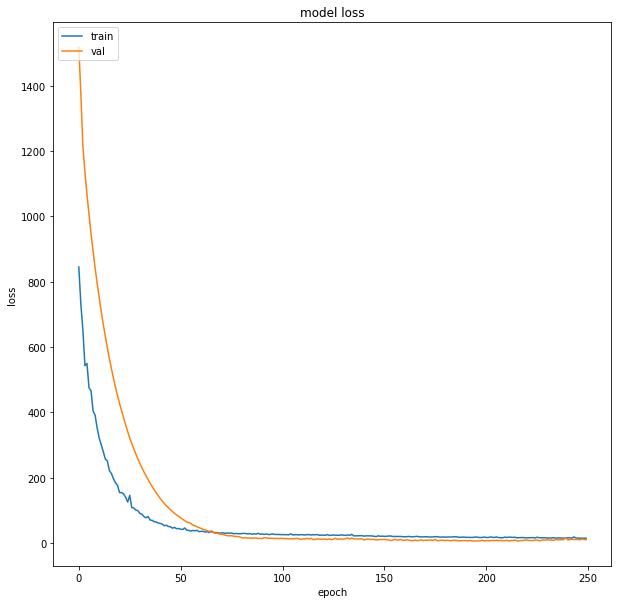

In [73]:
plot_model_result(history)

evaluate the trained model with test set

In [63]:
results = chili_model.evaluate(x_test, y_test, batch_size=5)

15/15 [==============================] - 0s 28ms/sample - loss: 57.4931


save the trained model weights into a h5 file so it can be loaded later (no need to re-train)

In [66]:
chili_model.save_weights("chili.h5")

## Try to predict Chili (bird's eye) price using Chili (red) forecasting model

In [67]:
df_chili_bird = drop_unused_row_column(df, "bird")
#Chili (bird’s eye) - Retail
data_bird = df_chili_bird["mp_price"].values / 1000
len(data_bird)

155

In [55]:
x, y, _, _ = split_data(data, len(data_bird), HISTORY_SIZE)

# test_bird = tf.data.Dataset.from_tensor_slices((x, y))
# test_bird = test_bird.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [65]:
chili_model.evaluate(x, y, batch_size=5)

145/145 [==============================] - 0s 1ms/sample - loss: 18.0606


18.060553674040168